In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [237]:
plt.rcParams["figure.figsize"] = [16,4]

pd.options.display.width = 0
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
np.set_printoptions(threshold=30)

In [238]:
def flatten(nested_lst):
    flattened_lst = [elem for lst in nested_lst for elem in lst]
    return flattened_lst

In [239]:
def prepare_test_data(data, stratify_crit, test_size=0.2, random_state=None):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, stratify_crit): # There is no loop really
        data_train = data.iloc[train_index].copy()
        data_test = data.iloc[test_index].copy()
    return data_train, data_test

In [240]:
def prepare_data_for_model(train, val_size=None, random_state=None):
    y = train[features["target"]].to_numpy().reshape(-1)
    X = train.drop(columns=features["target"])
    if val_size is not None:
        return train_test_split(X, y, test_size=val_size, random_state=random_state)
    return X, y

In [241]:
def drop_features(features, discarded):
    for key in features:
        for feat in discarded:
            if feat in features[key]:
                features[key].remove(feat)

In [242]:
housing = pd.read_csv("../data/AmesHousing.csv")

In [243]:
housing

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0         1  526301100           20        RL         141.0     31770   Pave   
1         2  526350040           20        RH          80.0     11622   Pave   
2         3  526351010           20        RL          81.0     14267   Pave   
3         4  526353030           20        RL          93.0     11160   Pave   
4         5  527105010           60        RL          74.0     13830   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
2925   2926  923275080           80        RL          37.0      7937   Pave   
2926   2927  923276100           20        RL           NaN      8885   Pave   
2927   2928  923400125           85        RL          62.0     10441   Pave   
2928   2929  924100070           20        RL          77.0     10010   Pave   
2929   2930  924151050           60        RL          74.0      9627   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
0      NaN       IR1          Lvl    AllPub     Corner        Gtl   
1      NaN       Reg          Lvl    AllPub     Inside        Gtl   
2      NaN       IR1          Lvl    AllPub     Corner        Gtl   
3      NaN       Reg          Lvl    AllPub     Corner        Gtl   
4      NaN       IR1          Lvl    AllPub     Inside        Gtl   
...    ...       ...          ...       ...        ...        ...   
2925   NaN       IR1          Lvl    AllPub    CulDSac        Gtl   
2926   NaN       IR1          Low    AllPub     Inside        Mod   
2927   NaN       Reg          Lvl    AllPub     Inside        Gtl   
2928   NaN       Reg          Lvl    AllPub     Inside        Mod   
2929   NaN       Reg          Lvl    AllPub     Inside        Mod   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
0           NAmes        Norm        Norm      1Fam      1Story             6   
1           NAmes       Feedr        Norm      1Fam      1Story             5   
2           NAmes        Norm        Norm      1Fam      1Story             6   
3           NAmes        Norm        Norm      1Fam      1Story             7   
4         Gilbert        Norm        Norm      1Fam      2Story             5   
...           ...         ...         ...       ...         ...           ...   
2925      Mitchel        Norm        Norm      1Fam        SLvl             6   
2926      Mitchel        Norm        Norm      1Fam      1Story             5   
2927      Mitchel        Norm        Norm      1Fam      SFoyer             5   
2928      Mitchel        Norm        Norm      1Fam      1Story             5   
2929      Mitchel        Norm        Norm      1Fam      2Story             7   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
0                5        1960            1960        Hip   CompShg   
1                6        1961            1961      Gable   CompShg   
2                6        1958            1958        Hip   CompShg   
3                5        1968            1968        Hip   CompShg   
4                5        1997            1998      Gable   CompShg   
...            ...         ...             ...        ...       ...   
2925             6        1984            1984      Gable   CompShg   
2926             5        1983            1983      Gable   CompShg   
2927             5        1992            1992      Gable   CompShg   
2928             5        1974            1975      Gable   CompShg   
2929             5        1993            1994      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
0         BrkFace      Plywood        Stone         112.0         TA   
1         VinylSd      VinylSd         None           0.0         TA   
2         Wd Sdng      Wd Sdng      BrkFace         108.0         TA   
3         BrkFace      BrkFace         None           0.0         Gd   
4         VinylSd      VinylSd

In [244]:
housing.describe()

Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2930.000000   2930.000000  2930.000000     2930.000000   2907.000000   
mean       6.094881      5.563140  1971.356314     1984.266553    101.896801   
std        1.411026      1.111537    30.245361       20.860286    179.112611   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1954.000000     1965.000000      0.000000   
50%        6.000000      5.000000  1973.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    164.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF   1st Flr SF  \
count   2929.000000   2929.000000  2929.000000    2929.000000  2930.000000   
mean     442.629566     49.722431   559.262547    1051.614544  1159.557679   
std      455.590839    169.168476   439.494153     440.615067   391.890885   
min        0.000000      0.000000     0.000000       0.000000   334.000000   
25%        0.000000      0.000000   219.000000     793.000000   876.250000   
50%      370.000000      0.000000   466.000000     990.000000  1084.000000   
75%      734.000000      0.000000   802.000000    1302.000000  1384.000000   
max     5644.000000   1526.000000  2336.000000    6110.000000  5095.000000   

        2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
count  2930.000000      2930.000000  2930.000000     2928.000000   
mean    335.455973         4.676792  1499.690444        0.431352   
std     428.395715        46.310510   505.508887        0.524820   
min       0.000000         0.000000   334.000000        0.000000   
25%       0.000000         0.000000  1126.000000        0.000000   
50%       0.000000         0.000000  1442.000000        0.000000   
75%     703.750000         0.000000  1742.750000        1.000000   
max    2065.000000      1064.000000  5642.000000        3.000000   

       Bsmt Half Bath    Full Bath    Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
count     2928.000000  2930.000000  2930.000000    2930.000000    2930.000000   
mean         0.061134     1.566553     0.379522       2.854266       1.044369   
std          0.245254     0.552941     0.502629       0.827731       0.214076   
min          0.000000     0.000000     0.000000       0.000000       0.000000   
25%          0.000000     1.000000     0.000000       2.000000       1.000000   
50%          0.000000     2.000000     0.000000       3.000000       1.000000   
75%          0.000000     2.000000     1.000000       3.000000       1.000000   
max          2.000000     4.000000     2.000000       8.000000       3.000000   

       TotRms AbvGrd   Fireplaces  Garage Yr Blt  Garage Cars  Garage Area  \
count    2930.000000  2930.000000    2771.000000  2929.000000  2929.000000   
mean        6.443003     0.599317    1978.132443     1.766815   472.819734   
std         1.572964     0.647921      25.528411     0.760566   215.046549   
min         2.000000     0.000000    1895.000000     0.000000     0.000000   
25%         5.000000     0.000000    1960.000000     1.000000   320.000000   
50%         6.000000     1.000000    1979.000000     2.000000   480.000000   
75%  

In [245]:
features = {
    "nominal": ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", 
              "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
              "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
              "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
              "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"],
    "ordinal": ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", 
              "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", 
              "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", 
              "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", 
              "Paved Drive", "Pool QC", "Fence"],
    "cont": ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", 
                 "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", 
                 "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", 
                 "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"],
    "discrete": ["Order", "Year Built", "Year Remod/Add", "Full Bath", "Half Bath", 
                "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt", 
                "Garage Cars", "Mo Sold", "Yr Sold"],
    "target": ["SalePrice"]
}

In [246]:
print("Nominal: {}\nOrdinal: {}\nContinuous: {}\nDiscrete: {}".format(
    len(features["nominal"]), len(features["ordinal"]), len(features["cont"]), len(features["discrete"])))

Nominal: 24
Ordinal: 23
Continuous: 19
Discrete: 13


In [247]:
housing["MS Zoning"] = housing["MS Zoning"].apply(str)

In [248]:
nominal_cat_dict = {
    'Lot Config': ["Inside", "Corner", "CulDSac", "FR2", "FR3"],
    'House Style': ["1Story", "1.5Fin", "1.5Unf", "2Story", "2.5Fin", "2.5Unf", "SFoyer", "SLvl"],
    'Land Contour': ["Lvl", "Bnk", "HLS", "Low"],
    'MS SubClass': ["20", "30", "40", "45", "50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
    'Exterior 2nd': ["AsbShng", "AsphShn", "Brk Cmn", "BrkFace", "CBlock", "CmentBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "Wd Shng"],
    'Garage Type': ["2Types", "Attchd", "Basment", "BuiltIn", "CarPort", "Detchd", "NA"],
    'Misc Feature': ["Elev", "Gar2", "Othr", "Shed", "TenC", "NA"],
    'Street': ["Grvl", "Pave"],
    'Roof Matl': ["ClyTile", "CompShg", "Membran", "Metal", "Roll", "Tar&Grv", "WdShake", "WdShngl"],
    'Sale Type': ["WD ", "CWD", "VWD", "New", "COD", "Con", "ConLw", "ConLI", "ConLD", "Oth"],
    'Sale Condition': ["Normal", "Abnorml", "AdjLand", "Alloca", "Family", "Partial"],
    'Alley': ["Grvl", "Pave", "NA"],
    'Condition 2': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Exterior 1st': ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
    'Neighborhood': ["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", 
                     "Gilbert", "Greens", "GrnHill", "IDOTRR", "Landmrk", "MeadowV", "Mitchel", "NAmes", 
                     "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", 
                     "Somerst", "StoneBr", "Timber", "Veenker"],
    'Roof Style': ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
    'Foundation': ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
    'MS Zoning': ["A (agr)", "C (all)", "FV", "I (all)", "RH", "RL", "RP", "RM"],
    'Central Air': ["N", "Y"],
    'Heating': ["Floor", "GasA", "GasW", "Grav", "OthW", "Wall"],
    'Bldg Type': ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
    'Condition 1': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Mas Vnr Type': ["BrkCmn", "BrkFace", "CBlock", "None", "Stone"],
}

In [249]:
ordinal_cat_dict = {
    'Kitchen Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Overall Cond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Exter Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Fence': ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
    'Bsmt Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Utilities': ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    'Electrical': ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    'Heating QC': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Garage Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Pool QC': ["NA", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Paved Drive': ["N", "P", "Y"], 
    'Land Slope': ["Sev", "Mod", "Gtl"], 
    'Lot Shape': ["IR3", "IR2", "IR1", "Reg"], 
    'Functional': ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    'BsmtFin Type 1': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Overall Qual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'Garage Finish': ["NA", "Unf", "RFn", "Fin"], 
    'BsmtFin Type 2': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Garage Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Fireplace Qu': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Exter Cond': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Exposure': ["NA", "No", "Mn", "Av", "Gd"]
}

In [250]:
nas = housing.isna().sum()
nas = nas[nas > 0].sort_values(ascending=False)
nas

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Lot Frontage       490
Garage Yr Blt      159
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Area          1
Electrical           1
dtype: int64

In [251]:
tofill_features = [
    'Pool QC', 'Misc Feature', 'Alley', 'Fence', 
    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Garage Finish', 
    'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2',
    'BsmtFin Type 1', 'Bsmt Cond', 'Bsmt Qual']

housing[tofill_features] = housing[tofill_features].fillna("NA")

In [252]:
discarded_features = ['PID', 'Order', 'Garage Yr Blt', 'Mas Vnr Type', 'Mas Vnr Area', 'Lot Frontage', 'MS SubClass']
drop_features(features, discarded_features)
housing = housing.drop(columns=discarded_features)

In [253]:
housing = housing.dropna()

In [254]:
housing.isna().sum().sort_values().tail()

Exter Qual      0
Exterior 2nd    0
Exterior 1st    0
Roof Style      0
SalePrice       0
dtype: int64

In [255]:
all_features = features["target"]+features["cont"]+features["discrete"]+features["ordinal"]+features["nominal"]
housing = housing[all_features]

In [256]:
housing[features["cont"]] = housing[features["cont"]].astype("float64")
housing[features["discrete"]] = housing[features["discrete"]].astype("int64")

In [257]:
ordinal_categories = [ordinal_cat_dict[key] for key in housing[features["ordinal"]].columns]
nominal_categories = [nominal_cat_dict[key] for key in housing[features["nominal"]].columns]

In [258]:
criteria = pd.cut(housing["SalePrice"], bins=20, labels=range(20))
train, test = prepare_test_data(housing, stratify_crit=criteria)

# Decision Tree

In [398]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
nominal_encoder = OneHotEncoder(categories=nominal_categories, drop=None)
y = train[features["target"]].to_numpy().reshape(-1)
X_cont = train[features["cont"]].to_numpy()
X_disc = train[features["discrete"]].to_numpy()
X_ord = ordinal_encoder.fit_transform(train[features["ordinal"]])
X_nom = nominal_encoder.fit_transform(train[features["nominal"]]).toarray()

In [399]:
X = np.hstack((X_cont, X_disc, X_ord, X_nom))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [400]:
model_tree = DecisionTreeRegressor()
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_val)
model_tree.score(X_val, y_val)

0.7298435961571039

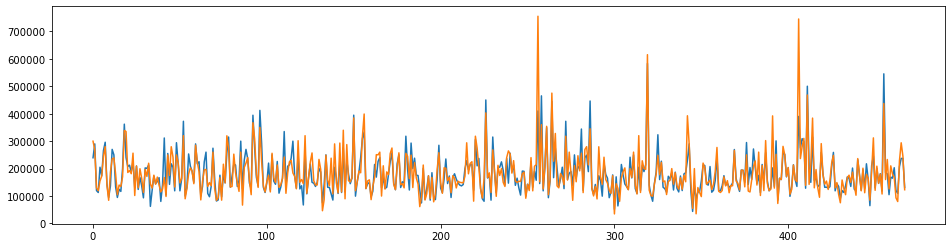

In [401]:
plt.plot(y_pred)
plt.plot(y_val)

In [158]:
important_features_idx = np.flip(np.argsort(model_tree.feature_importances_)[-20:])
importances = model_tree.feature_importances_[important_features_idx]
most_important_features = list(zip(important_features_idx, importances))
most_important_features

[(31, 0.6540838377246083),
 (8, 0.10020245253607533),
 (4, 0.03069525331340466),
 (6, 0.029005898887142976),
 (5, 0.028468539923666835),
 (0, 0.025802461252690107),
 (1, 0.01618283740496794),
 (17, 0.013269736166641026),
 (45, 0.01103693854882099),
 (9, 0.010676645103166467),
 (38, 0.008925630189598806),
 (18, 0.008026623670297032),
 (11, 0.007708312438146446),
 (32, 0.006454580131704872),
 (3, 0.005541075464138214),
 (21, 0.004350258620162493),
 (26, 0.0036835716520884744),
 (179, 0.002988710743555758),
 (42, 0.002596851537331499),
 (199, 0.002140848886713678)]

In [159]:
[(train.columns[index+1], importance) for index, importance in most_important_features if index <= 50]

[('Overall Qual', 0.6540838377246083),
 ('Gr Liv Area', 0.10020245253607533),
 ('Total Bsmt SF', 0.03069525331340466),
 ('2nd Flr SF', 0.029005898887142976),
 ('1st Flr SF', 0.028468539923666835),
 ('Lot Area', 0.025802461252690107),
 ('BsmtFin SF 1', 0.01618283740496794),
 ('Year Built', 0.013269736166641026),
 ('Garage Finish', 0.01103693854882099),
 ('Garage Area', 0.010676645103166467),
 ('BsmtFin Type 1', 0.008925630189598806),
 ('Year Remod/Add', 0.008026623670297032),
 ('Open Porch SF', 0.007708312438146446),
 ('Overall Cond', 0.006454580131704872),
 ('Bsmt Unf SF', 0.005541075464138214),
 ('Bedroom AbvGr', 0.004350258620162493),
 ('Mo Sold', 0.0036835716520884744),
 ('Kitchen Qual', 0.002596851537331499)]

In [160]:
importances.sum()

0.971841064194922

# Random Forest

In [409]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
y = train[features["target"]].to_numpy().reshape(-1)
X_cont = train[features["cont"]].to_numpy()
X_disc = train[features["discrete"]].to_numpy()
X_ord = ordinal_encoder.fit_transform(train[features["ordinal"]])

In [410]:
X = np.hstack((X_cont, X_disc, X_ord))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [411]:
model_forest = RandomForestRegressor(n_estimators=1000)
model_forest.fit(X_train, y_train)
y_pred = model_forest.predict(X_val)
model_forest.score(X_val, y_val)

0.8489310982749184

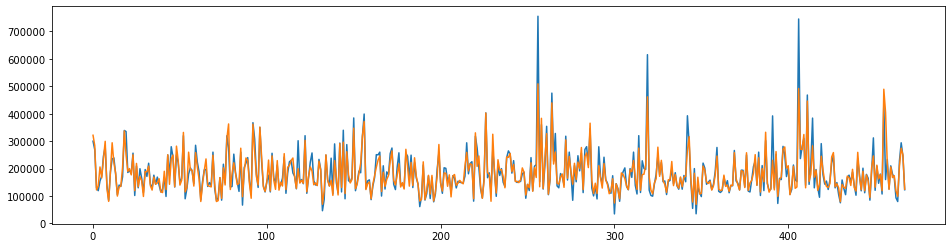

In [412]:
plt.plot(y_val)
plt.plot(y_pred)

In [213]:
important_features_idx = np.flip(np.argsort(model_forest.feature_importances_)[-20:])
importances = model_forest.feature_importances_[important_features_idx]
important_features = train.drop(columns=features["target"]).iloc[:,important_features_idx].columns
most_important_features = list(zip(important_features, importances))
most_important_features

[('Overall Qual', 0.5939765613541499),
 ('Gr Liv Area', 0.1279897526710978),
 ('Total Bsmt SF', 0.03531614235409219),
 ('1st Flr SF', 0.028398410176978812),
 ('BsmtFin SF 1', 0.022307926136566347),
 ('Bsmt Qual', 0.020432624956686272),
 ('2nd Flr SF', 0.020419228153699166),
 ('Lot Area', 0.020232759844847608),
 ('Year Built', 0.016325564449546644),
 ('Garage Area', 0.012600079626635709),
 ('Year Remod/Add', 0.011629078163233003),
 ('Kitchen Qual', 0.008496666393968315),
 ('Garage Cars', 0.007938958147627101),
 ('Garage Finish', 0.007144132457109962),
 ('Full Bath', 0.006331414171073924),
 ('TotRms AbvGrd', 0.00609106363515365),
 ('Bsmt Unf SF', 0.00522026028574325),
 ('BsmtFin Type 1', 0.0049638099934777085),
 ('Open Porch SF', 0.0049006416567480005),
 ('Overall Cond', 0.004327182684603042)]

In [428]:
sel_cont = ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 
            'BsmtFin SF 1', 'Lot Area', 'Garage Area']
sel_ord = ['Overall Qual', 'Bsmt Qual']
sel_disc = ['Year Built']

ordinal_encoder = OrdinalEncoder(categories=[ordinal_cat_dict['Overall Qual'], ordinal_cat_dict['Bsmt Qual']])
X_cont = train[sel_cont].to_numpy()
X_disc = train[sel_disc].to_numpy()
X_ord = ordinal_encoder.fit_transform(train[sel_ord])

In [430]:
X = np.hstack((X_cont, X_disc, X_ord))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [433]:
model_forest = RandomForestRegressor(n_estimators=1000)
model_forest.fit(X_train, y_train)
y_pred = model_forest.predict(X_val)
model_forest.score(X_val, y_val)

0.844937471218161

# Linear Regression

In [284]:
important_features = train.corr()["SalePrice"].abs().sort_values(ascending=False)
important_features

SalePrice          1.000000
Overall Qual       0.795205
Gr Liv Area        0.713996
Garage Cars        0.651024
Garage Area        0.646292
Total Bsmt SF      0.639759
1st Flr SF         0.631676
Year Built         0.557773
Full Bath          0.544329
Year Remod/Add     0.528836
TotRms AbvGrd      0.502718
Fireplaces         0.474684
BsmtFin SF 1       0.450785
Open Porch SF      0.311442
Wood Deck SF       0.305369
Half Bath          0.286044
2nd Flr SF         0.278612
Lot Area           0.276489
Bsmt Unf SF        0.175343
Bedroom AbvGr      0.155160
Kitchen AbvGr      0.124355
Enclosed Porch     0.123214
Overall Cond       0.111158
Screen Porch       0.110598
Pool Area          0.083703
Low Qual Fin SF    0.048344
Mo Sold            0.047653
Yr Sold            0.030574
Misc Val           0.022029
3Ssn Porch         0.021188
BsmtFin SF 2       0.017101
Name: SalePrice, dtype: float64

In [355]:
train[important_features[1:20].index].head()

Overall Qual  Gr Liv Area  Garage Cars  Garage Area  Total Bsmt SF  \
2525             7       2156.0            2        508.0         1568.0   
1927             6       1657.0            2        484.0         1657.0   
1841             7       1250.0            2        528.0          625.0   
1409             6       2108.0            2        540.0         1127.0   
1286             5       1323.0            2        400.0          780.0   

      1st Flr SF  Year Built  Full Bath  Year Remod/Add  TotRms AbvGrd  \
2525      2156.0        1968          2            2003              9   
1927      1657.0        1970          2            1970              7   
1841       625.0        2006          2            2007              5   
1409      1236.0        1935          2            1986              7   
1286       948.0        1948          1            2005              6   

      Fireplaces  BsmtFin SF 1  Open Porch SF  Wood Deck SF  Half Bath  \
2525           1         297.0           80.0           0.0          0   
1927           1        1237.0            0.0           0.0          0   
1841           0           0.0           54.0           0.0          1   
1409           2         626.0            0.0           0.0          0   
1286           0           0.0            0.0           0.0          0   

      2nd Flr SF  Lot Area  Bsmt Unf SF  Bedroom AbvGr  
2525         0.0   20781.0       1203.0              3  
1927         0.0   12155.0        420.0              3  
1841       625.0    4251.0        625.0              2  
1409       872.0   13728.0        501.0              4  
1286       375.0    9184.0        780.0              3

In [292]:
train[sel_features]

Gr Liv Area  Garage Area  Total Bsmt SF  Overall Qual  Full Bath  \
2525       2156.0        508.0         1568.0             7          2   
1927       1657.0        484.0         1657.0             6          2   
1841       1250.0        528.0          625.0             7          2   
1409       2108.0        540.0         1127.0             6          2   
1286       1323.0        400.0          780.0             5          1   
...           ...          ...            ...           ...        ...   
1941        924.0        420.0          924.0             5          1   
1164       1392.0        540.0          689.0             7          2   
1834       1378.0        540.0         1378.0             8          2   
618        1644.0        418.0         1416.0             6          1   
199        1536.0        480.0          928.0             5          2   

      Garage Cars  Year Built  Year Remod/Add  
2525            2        1968            2003  
1927            2        1970            1970  
1841            2        2006            2007  
1409            2        1935            1986  
1286            2        1948            2005  
...           ...         ...             ...  
1941            1        1952            1952  
1164            2        2007            2007  
1834            2        2004            2004  
618             2        1953            1953  
199             2        1930            1950  

[2340 rows x 8 columns]

In [353]:
cont_features = ["Gr Liv Area"]
ord_features = ["Overall Qual"]
disc_features = ["Year Built"]

In [354]:
standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=[range(1,11)])
y = train[features["target"]].to_numpy().reshape(-1)
X_cont = standard_scaler.fit_transform(train[["Gr Liv Area"]])
X_ord = ordinal_encoder.fit_transform(train[["Overall Qual"]])
X_disc = train[["Year Built"]].to_numpy()

In [351]:
X = np.hstack((X_cont, X_ord, X_disc))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [352]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_pred = model_linear.predict(X_val)
model_linear.score(X_val, y_val)

0.7106267973622578

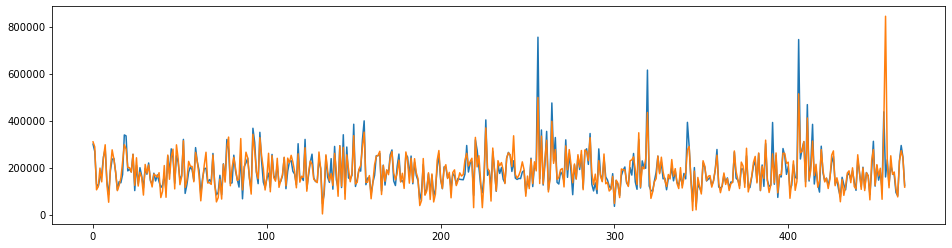

In [282]:
plt.plot(y_val)
plt.plot(y_pred)

# Lasso

In [389]:
standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
y = train[features["target"]].to_numpy().reshape(-1)
X_cont = standard_scaler.fit_transform(train[features["cont"]])
X_disc = train[features["discrete"]].to_numpy()
X_ord = ordinal_encoder.fit_transform(train[features["ordinal"]])

In [390]:
X = np.hstack((X_cont, X_disc, X_ord))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [392]:
model_lasso = Lasso(max_iter=10000)
model_lasso.fit(X_train, y_train)
model_lasso.score(X_val, y_val)

0.7217843057417976

# Ridge

In [393]:
# Ridge

standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
y = train[features["target"]].to_numpy().reshape(-1)
X_cont = standard_scaler.fit_transform(train[features["cont"]])
X_disc = train[features["discrete"]].to_numpy()
X_ord = ordinal_encoder.fit_transform(train[features["ordinal"]])

X = np.hstack((X_cont, X_disc, X_ord))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

model_ridge = Ridge(max_iter=10000)
model_ridge.fit(X_train, y_train)
model_ridge.score(X_val, y_val)

0.7219080086968308